## Intermediate Machine Learning: Assignment 1

**Deadline**

Assignment 1 is due Thursday, September 25 11:59 pm. Late work will not be accepted as per the course policies (see the syllabus on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf on Gradescope. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the pdf on Colab, you can simply use File -> Print (Cmd/Ctrl+P). Please be sure that all of your work appears in the output, and that long lines are not truncated in any cell.

**Topics**

 * Lasso
 * Bias-variance decomposition
 * Mercer kernels
 * LOOCV for kernel smoothing

This assignment will also help to solidify your Python and Jupyter notebook skills.


### Problem 1: Roping variables with the lasso (15 points)

In this exercise, we'll employ the lasso regression technique to identify key predictor variables from the diabetes dataset. This dataset is used in the study by Efron, Hastie, Johnstone, and Tibshirani (2004, *Annals of Statistics*, "Least Angle Regression"). The primary goal is to predict a quantitative measure of diabetes progression one year after baseline, based on ten standardized physiological and biochemical measurements.


The *Diabetes* dataset in the `sklearn.datasets` package is a classic benchmark for regression. It contains 442 samples with 10 features that have been centered to mean zero but not scaled to unit variance. The predictors include age, sex, body mass index (BMI), blood pressure (BP), and six blood serum measures (s1–s6: cholesterol, LDL, HDL, cholesterol/HDL ratio, triglycerides, and blood sugar). The target is a quantitative measure of diabetes progression one year after baseline. You can find details at https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset.

**Your tasks are as follows**:

1. **Plotting Lasso Paths**: Generate a visualization of the lasso regularization paths.
2. **Identifying Key Predictors**: Determine which coefficients of \( \beta \) are non-zero.
3. **Estimating Coefficients**: Provide the best estimate for these non-zero coefficients.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes
%matplotlib inline

Just run the next cell to read in the data.

In [18]:
X, y = load_diabetes(return_X_y=True)
n, p = X.shape
print("Number of rows: {}".format(n))
print("Number of columns: {}".format(p))

Number of rows: 442
Number of columns: 10


### 1.1: Lasso regularization paths

Run the lasso and plot the regularization paths. You can use the `Lasso` class from the `sklearn.linear_model` package. Plot the parameter paths with the regularization level $\lambda$ (`alpha` in the code) on the log-scale, as done in the lasso demo code from class. (As always, be sure to label your axes.)

Show two plots, one where you run the lasso on the variables as given in the dataset, another where you standardize the variables to have mean zero and standard deviation one. Describe the differences in the regularization paths, and explain those differences.

When the predictors are standardized, what order do they appear in the lasso fits? That is, as $\lambda$ decreases from infinity to zero, what is the sequence of variables that enter the model with nonzero coefficients? Explain why this ordering may (or may not) make sense.



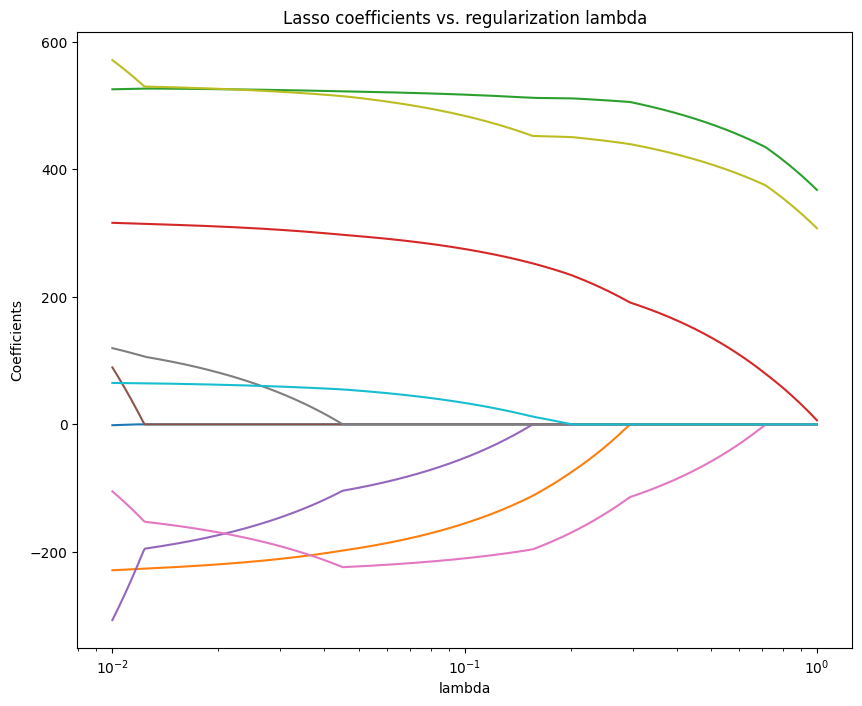

In [8]:
from sklearn.linear_model import Lasso
#no standardization

alphas = np.linspace(0.01,1,10000)
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients vs. regularization lambda');

In [17]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
Xx = diabetes.data
yy = diabetes.target
feature_names = diabetes.feature_names
print(feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


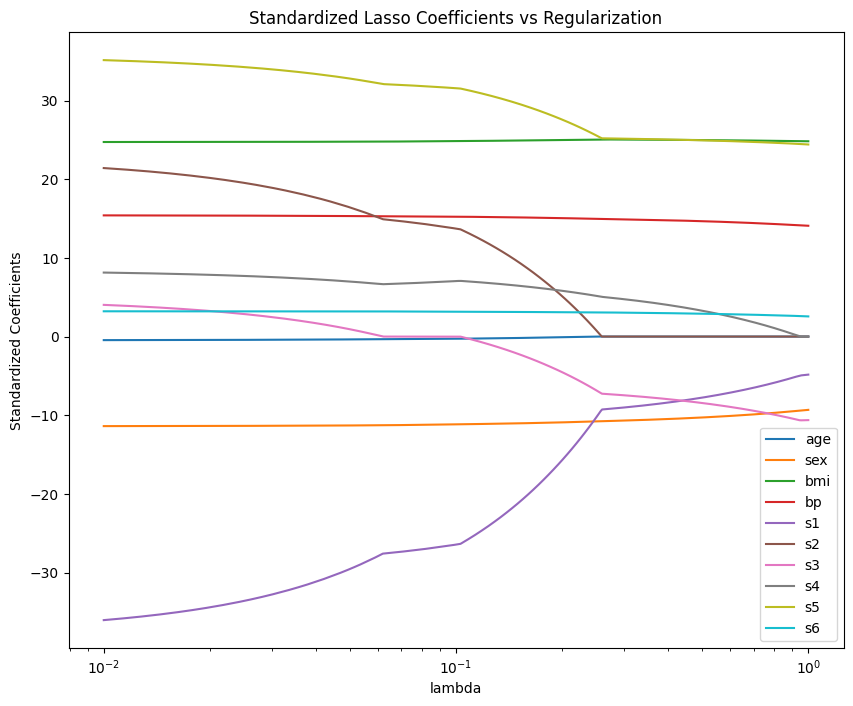

In [19]:
#with standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.linspace(0.01,1,10000)
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# Feature names
feature_names = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

# Plot
plt.figure(figsize=(10, 8))
for i, name in enumerate(feature_names):
    plt.plot(alphas, coefs[:, i], label=name)

plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('Standardized Coefficients')
plt.title('Standardized Lasso Coefficients vs Regularization')
plt.legend(loc='best')
plt.axis('tight')
plt.show()

**Differences in regulurization paths**
For standardized coefficients, as lambda increases, the regularization path is more balanced and smooth compared to non-standardized. As a result, standardized coefficients shrink towards zero at a similar pace while some non-standardized coefficients reach zero very quickly. This happens because shrinking depends on the variable scale. Since Lasso penalizes all coefficients equally, small-scale features are penalized more relative to their magnitude which may cause them to reach zero quickly.

**Features order**
In the standardized regularization, the order in which coefficients reach zero is s6 (blood sugar), s2 (LDL) , s4 (cholesterol/HDL ratio) and the other coefficients don't reach zero. That’s a reasonable pattern in biomedical data: blood sugar can be strongly correlated with other lipid measures, LDL with total cholesterol, etc. Lasso will drop whichever is most redundant given the rest.

### 1.2: Select, estimate, and predict

The true model is linear, and only a subset $S \subset \{0,1,\ldots, 49\}$ of the 50 variables have non-zero coefficients $\beta_j$. In this problem you should make three estimates:

1. An estimate $\hat S$ of $S$
2. An estimate $\hat \beta_j$ for each $j\in \hat S$
3. An estimate of the predictive risk ${\mathbb E}(Y - X\hat\beta)^2$


We are not specifying how you should construct these estimates. You should use your judgement, taste, and
the tools provided from class. However, you must clearly explain and justify whatever approach that you use.


**Step 1**. Choose optimal $\lambda$ by LOOCV, fit Lasso on optimal lambda and select non-zero coefficients to be $\hat{S}$.

In [22]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

lasso_cv = LassoCV(cv=loo, n_alphas=100, random_state=0)
lasso_cv.fit(X_scaled, y)
best_lambda = lasso_cv.alpha_
best_lambda

np.float64(1.0432552660691838)

In [29]:
lasso_coef = lasso_cv.coef_
hat_S = [i for i, c in enumerate(lasso_coef) if c != 0]
hat_S
selected_features = [feature_names[i] for i in hat_S]
selected_features

['sex', 'bmi', 'bp', 's1', 's3', 's5', 's6']

**Step 2**. Find $\beta_j$ for each $j$ in $\hat{S}$

In [30]:
lasso_coefs_selected = lasso_cv.coef_[hat_S]

results = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lasso_coefs_selected
})
results

,feature,coefficient
0,sex,-9.243644
1,bmi,24.822303
2,bp,14.049318
3,s1,-4.747136
4,s3,-10.598169
5,s5,24.365734
6,s6,2.524406


**Step 3.** Estimate predictive risk via LOOCV from optimal $\lambda$ in Step 2.

In [33]:
preds = lasso_cv.predict(X_scaled)
print('Predictive Risk: ', np.mean((y - preds)**2))

Predictive Risk:  2886.85045850392


### Problem 2: Risky business (10 points)

In class [(and in these notes)](https://github.com/YData123/sds365-fa22/raw/main/notes/kernel-bias-variance.pdf) we sketched a proof that, when the regression function has two bounded derivatives,
 the bias and variance for kernel smoothing scale as

$$ \mbox{bias}^2 = O\left(h^4\right)$$
$$ \mbox{var} = O\left(\frac{1}{nh^p}\right).$$

Here $h$ is the bandwidth parameter, $n$ is the sample size, and $p$ is the number of predictor variables. These expressions are asymptotic, meaning that they apply as $n$ gets large and $h$ gets small.  In this problem your job is to reason about the implications of this bias-variance decomposition for prediction.

*Note:* For this problem, you may either enter your answers in Markdown using $\rm\LaTeX$, or you write them on paper and scan to insert as an image in the notebook; whichever you prefer.


### 2.1 Selecting the optimal bandwidth

Suppose that the bias and variance are such that

$$ \mbox{bias}^2(\hat m(x))  \leq c_1 h^4 $$
$$ \mbox{var}(\hat m(x)) \leq c_2 \frac{1}{nh^p}.$$

for two constants $c_1$ and $c_2$. Using these expressions and a little calculus, determine the optimal bandwidth $h$ to minimize the risk function

$$R(h) = {\mathbb E}\left(\hat m(x) - m(x)\right)^2.$$

Your answer should involve the constants $c_1, c_2$, and $n$ and $p$. Give a bound on the resulting risk using this bandwidth.


### 2.2 Bandwith selection without tears

Now, going back to the expressions $\mbox{bias}^2 = O\left(h^4\right)$ and $ \mbox{var} = O\left(\displaystyle\frac{1}{nh^p}\right)$, explain why the scaling of the optimal bandwidth (as a function of $n$ and $p$), must satisfy
$\mbox{bias}^2  \approx \mbox{var}$; that is, they must be of the same order as $h\to 0$. Then, without using any calculus, use this argument to determine the optimal scaling of the bandwidth and the fastest rate at which the
risk $R(h) = {\mathbb E}\left(\hat m(x) - m(x)\right)^2$ can approach zero as the sample size increases.


### 2.3 The cursed COD

Using the risk bound you derive above, make a plot that demonstrates the curse of dimensionality by plotting the sample size required to achieve a given level of risk. Specifically, let the target risk $R$ vary between 0.1 and 0.5, and let the dimension $p$ vary between 1 and 20, and plot the sample size required to achieve that risk. Give a single plot that shows the collection of curves for each dimension.




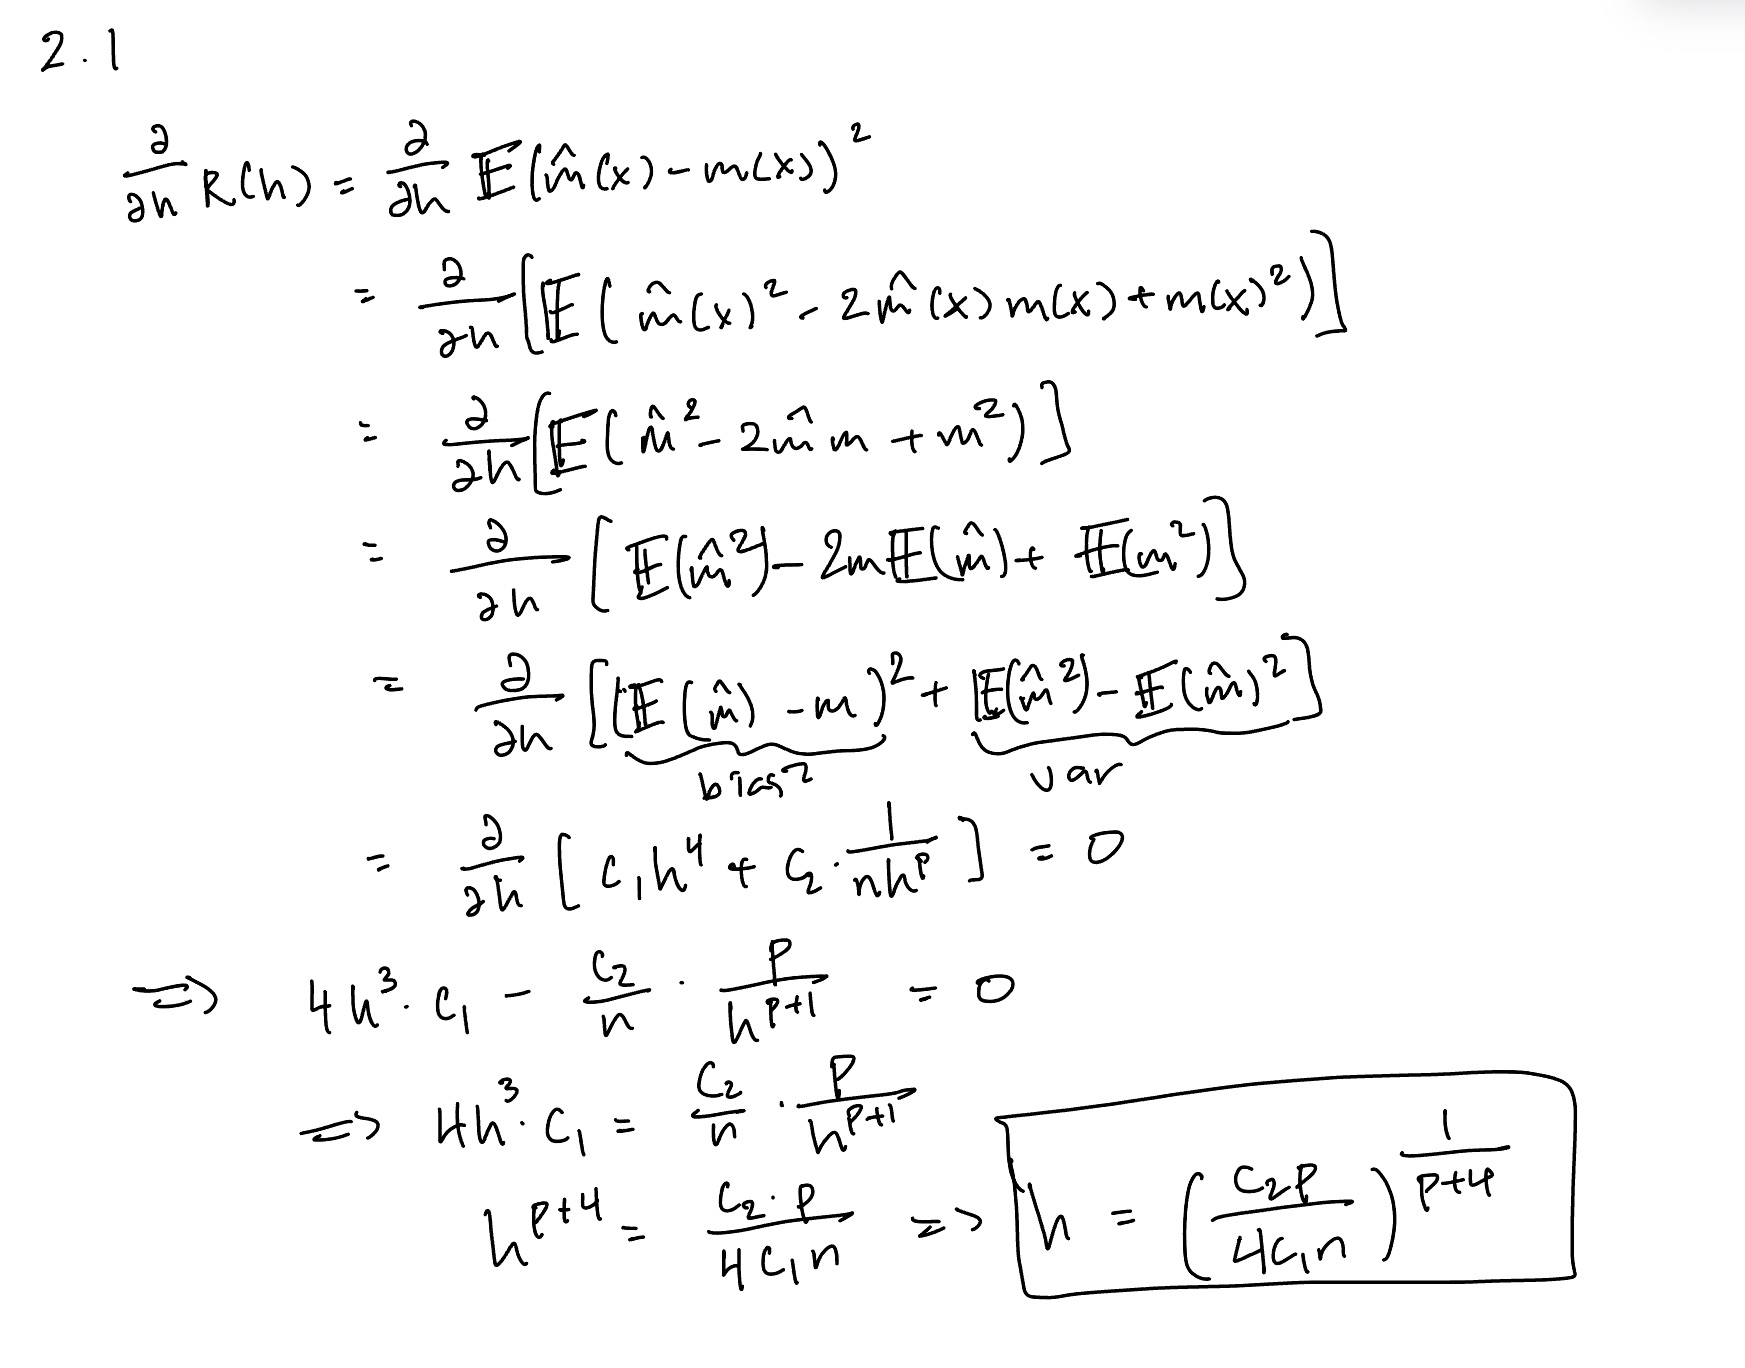

In [ ]:
# your code and markdown with derivations here

### Problem 3: A kernel of truth (15 points)

For problem you will implement nonparametric regression using Mercer kernels and penalization, in 1-dimension. This can be compared to regression using smoothing kernels.

As discussed in lecture, nonparametric regression with Mercer kernels is based on the infinite dimensional ridge regression

$$ \hat m = \mbox{argmin} \| Y - m \|^2 + \lambda \|m\|_K^2$$

By the representer theorem, this is equivalent to setting $\hat m(x) = \sum_{i=1}^n \hat \alpha_i K(X_i, x)$ and
using the finite dimensional optimization

$$ \hat \alpha = \mbox{argmin} \| Y - {\mathbb K} \alpha \|^2 + \lambda \alpha^T {\mathbb K} \alpha$$

###  3.1 Solve

Derive a closed-form expression for the minimizer $\hat\alpha$. Show all of the steps in your derivation,
and justify each step. (As above, you may either enter your answers in Markdown using $\rm\LaTeX$, or insert an image of your handwritten solution.)


###  3.2 Implement

Next you will use your solution above and implement Mercer kernel regression. We give some starter code.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from time import sleep

The following cell defines some "helper functions" for this exercise. You don't need to change any of this code.
(If you do want to make changes, just describe what you did and why.)

In [21]:
def plot_estimate(x, f, fhat, X, y, sigma, lmbda, sleeptime=.01):
    clear_output(wait=True)
    plt.figure(figsize=(10,6))
    plt.plot(x, f, color='red', linewidth=2, label='true function')
    plt.plot(x, fhat, color='blue', linewidth=2, label='estimated function')
    plt.scatter(X, y, color='black', alpha=.5, label='random sample')
    plt.ylim(np.min(f)-4*sigma, np.max(f)+4*sigma)
    plt.legend(loc='upper left')
    plt.title('lambda: %.3g' % lmbda)
    plt.xlabel('x')
    plt.ylabel('estimated m(x)')
    plt.show()
    sleep(sleeptime)

def true_fn(x):
    return 3*x**2

def run_simulation(kernel, lmbdas, show_bias_variance=True):
    min_x, max_x = -1, 1
    x = np.linspace(min_x, max_x, 100)
    f = true_fn(x)
    sigma = .25
    estimates = []
    trials = 500

    for lmbda in lmbdas:
        estimates_lambda = []
        for i in np.arange(trials):
            X = np.sort(np.random.uniform(low=min_x, high=max_x, size=50))
            fX = true_fn(X)
            y = fX + sigma*np.random.normal(size=len(X))
            fhat = mercer_kernel_regress(kernel, X, y, x, lmbda=lmbda)
            if i % 50 == 0:
                plot_estimate(x, f, fhat, X, y, sigma, lmbda)
            estimates_lambda.append(fhat)
        estimates.append(estimates_lambda)

    if show_bias_variance == False:
        return

    fhat = np.array(estimates)
    sq_bias = np.zeros(len(lmbdas))
    variance = np.zeros(len(lmbdas))

    for i in np.arange(len(lmbdas)):
        sq_bias[i] = np.mean((np.mean(fhat[i], axis=0) - f)**2)
        variance[i] = np.mean(np.var(fhat[i], axis=0))

    plt.figure(figsize=(10,6))
    plt.plot(lmbdas, sq_bias, label='squared bias', linewidth=2)
    plt.plot(lmbdas, variance, label='variance', linewidth=2)
    plt.plot(lmbdas, sq_bias + variance, label='risk')
    plt.legend()
    plt.show()


Your job is to implement Mercer kernel regression and run it on two
different kernel functions. The two kernels could simply be the Gaussian kernel
with two different bandwidths, or you might experiment with other kernels.

The function `mercer_kernel_regress` takes a kernel, training data `X` and `y`, an array of values `x` to evaluate the function on, and a regularization parameter. You'll use your derivation above to
determine the coefficients $\alpha$. For some clues and suggestions on how to do the
implementation, see our demo code for smoothing kernels. You need to do something very similar.


In [ ]:
def mercer_kernel_regress(kernel, X, y, x, lmbda):
    # your implementation here
    _

def kernel1(x,y):
    # your implementation here
    _


def kernel2(x,y):
    # your implementation here
    _

###  3.3 Run two simulations and select regularization parameters

Finally, using our starter code and your own implementation above, run two simulations, one
using `kernel1` and the other using `kernel2`. After each simulation, select a regularization level from the bias-variance tradeoff, and then run a final simulation with that regularization level. In the following
starter code, you only need to specify the sequence of regularization parameters.


In [ ]:
lmbdas = # define your sequence of lambdas
run_simulation(kernel1, lmbdas)

In [ ]:
lambda_hat = # set the optimal lambda
run_simulation(kernel1, [lambda_hat], show_bias_variance=False)

In [ ]:
lmbdas = # define your sequence of lambdas
run_simulation(kernel2, lmbdas)

### Problem 4: An algebraic simplification of LOOCV (15 points)

Leave-One-Out Cross Validation (LOOCV) is a specific type of
$K$-fold cross validation where $K$ equals the number of observations in the dataset.
It works as follows for a training set with $n$ observations:

1. A single observation is used as the validation set,
    and the remaining $n-1$ observations serve as the training set.
2. A model is trained on the $n-1$ observations and
    validated on the single left-out observation.
3. This process is repeated $n$ times, each time leaving out a different
    observation as the validation set.
4. The LOOCV error is then the average error across all $n$ trials.

LOOCV is particularly useful because:
- It utilizes almost all the data for training,
    so it's less prone to high variance compared to other validation schemes.
- Since each observation is tested exactly once,
    LOOCV provides a very thorough out-of-sample testing mechanism.

However, it can be computationally expensive because you have to fit the model $n$ times.
    Luckily, for some models, there are algebraic simplifications available
    that make it computationally efficient.
    Expressing LOOCV in terms of the hat matrix allows for efficient
    computation of the LOOCV error without the need to refit the model for
    each left-out observation, making it a valuable tool for model evaluation.

Recall that the LOOCV error can be expressed as:

$$ LOOCV = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_{-i} \right)^2, $$

where $\hat{y}_{-i}$ represents the prediction for the $i^{th}$ observation
when it's left out from the training process.
In the following questions, you will be deriving an alternative expression
of the LOOCV error for both kernel and ridge regression, following the hints below.

### 1. LOOCV for kernel smoothing:

For kernels, we know that the LOOCV error can be equivalently written as the following form:

$$ LOOCV = \frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat y_i}{1 - L_{ii}} \right)^2, $$
where $\hat y_i$ is the predicted value from the model fit on all data, and
$L_{ii}$ is the $i^{th}$ diagonal element of the hat matrix $L$.

For kernel regression, we have
$$ \hat{y} = L y, $$
where
- $ \hat{y} $ is the vector of predictions.
- $ y $ is the observed response values.
- $ L $ is the hat matrix and is defined by the kernel (for a given bandwidth).
So, each diagonal element $ L_{ii} $ of the matrix $ L $ is defined as:
$$ L_{ii} = \frac{K\left(x_i, x_i\right)}{\sum_{j=1}^{n} K\left(x_i, x_j\right)}, $$
where
- $ K $ is the kernel function.
- $ x_i $ and $ x_j $ are the predictor values for observations $ i $ and $ j $, respectively.

The diagonal elements $ L_{ii} $ give the "leverage" of each observation, which can be interpreted as the influence an observation has on its own prediction.

Derive this alternative expression of the LOOCV error for kernel regression. That's to say, for kernel regression, prove that

$$ y_i - \hat{y}_{-i}  =  \frac{y_i - \hat y_i}{1 - L_{ii}}$$

In [ ]:
# Your markdown here.

## Problem 5: LASSO and Elastic Net

In class, we derived the solution for the one-dimensional LASSO using convexity and subgradients. We also know that coordinate descent can be used to solve LASSO in the high-dimensional case. Sometimes, we introduce a penalty that is a mixture of the $\ell_1$ and $\ell_2$ norms,  

$$
\lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|_2^2,
$$  

which is referred to as the **Elastic Net**. This problem demonstrates how the Elastic Net can be computed using the LASSO.

Let us first recall the one-dimensional LASSO objective:

$$
f(\beta) = \frac{a}{2}\beta^2 - b\beta + \lambda |\beta|,
\qquad a > 0,\; \lambda \ge 0.
$$

The minimizer is given by

$$
\widehat{\beta} = \frac{\operatorname{sign}(b)\,\big(|b| - \lambda\big)_+}{a},
$$

where $(x)_+ = \max\{x,0\}$.

5.1 Solve the one-dimensional LASSO problem

$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n}\sum_{i=1}^n (y_i - \beta x_i)^2 + \lambda |\beta| \right\},
$$

where $\lambda \geq 0$ and at least one $x_i \neq 0$.

In [ ]:
# Your markdown here.

5.2 Solve the one-dimensional Elastic Net
$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n} \sum_{i=1}^n (y_i - \beta x_i)^2 + \lambda_1 |\beta| + \lambda_2 \beta^2 \right\},
$$

where $\lambda_1 \geq 0$, $\lambda_2 \geq 0$, and at least one $x_i \neq 0$.  

*Hint:* Convert this problem into the form of 5.1. What happens if we observe a new data point $(\sqrt{2n\lambda_2}, 0)$?

In [ ]:
# Your markdown here.

5.3 Now consider the case where we have data $\mathbf{Y} \in \mathbb{R}^n$ and $\mathbf{X} \in \mathbb{R}^{n \times p}$. We want to find an estimator

$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n}\| \mathbf{Y} - \mathbf{X}\beta\|_2^2 + \lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|_2^2 \right\}.
$$

Assume we have access to an oracle that can solve the LASSO. How can we use it to solve the Elastic Net?  

*Hint:* Construct augmented variables $\mathbf{Y}^*$ and $\mathbf{X}^*$
(not necessarily the same shapes as $\mathbf{Y}$ and $\mathbf{X}$) and show that the objective is equivalent to
$$
\frac{1}{2\,\mathrm{len}(\mathbf{Y}^*)}
\|\mathbf{Y}^* - \mathbf{X}^*\beta\|_2^2
+ \lambda_1 \|\beta\|_1.
$$

In [ ]:
# Your markdown here.

5.4 Now revisit the diabetes dataset from the first problem. Apply the result you derived, together with the `Lasso` implementation from `sklearn.linear_model`, to solve the elastic net. Specifically, we want to solve

$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n}\|\mathbf{Y} - \mathbf{X}\beta\|_2^2
+ \lambda_1 \|\beta\|_1
+ \lambda_2 \|\beta\|_2^2 \right\},
$$
where $\lambda_1 = \lambda_2 = 0.1$.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
%matplotlib inline
X, y = load_diabetes(return_X_y=True)
X = np.hstack([np.ones((X.shape[0], 1)), X])
n, p = X.shape
n, p = X.shape

lambda1,lambda2 = 0.1, 0.1
# y_star = your code here
# X_star = your code here
model = Lasso(alpha=lambda1, fit_intercept=False)
model.fit(X_star, y_star)
your_coef = model.coef_

# You can use the following code to verify your answer
from sklearn.linear_model import ElasticNet
lambda1, lambda2 = 0.1, 0.1
alpha = lambda1 + 2 * lambda2
l1_ratio = lambda1 / (lambda1 + 2 * lambda2)

# Fit ElasticNet with your X, y
model = ElasticNet(alpha=alpha,
                   l1_ratio=l1_ratio,
                   fit_intercept=False,
                   max_iter=10000,
                   tol=1e-6,
                   selection='cyclic')

model.fit(X, y)
elastic_coef = model.coef_
print(np.linalg.norm(your_coef - elastic_coef)/np.linalg.norm(elastic_coef))  # should be a very small number

5.5 Which values of $\lambda_1$ and $\lambda_2$ are appropriate? A common approach is to use cross-validation. For simplicity, split the data once into training and validation sets, fit the model with different $(\lambda_1,\lambda_2)$, and compare the mean squared error (MSE) on the validation set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=365)
scalerX, scalery = StandardScaler(), StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.reshape(-1,1)).ravel()
y_test = scalery.transform(y_test.reshape(-1,1)).ravel()
grid = np.linspace(0.001, 1.0, 30)
params = []
mses = []
for lambda1 in grid:
    for lambda2 in grid:
        # fit a elastic net with lambda1 and lambda2 on (X_train, y_train)
        # compute the mse on (X_test, y_test)
        # you should use Lasso from sklearn. don't use ElasticNet.
        params.append((lambda1, lambda2))
        mses.append(mse)
your_lambda1,your_lambda2 = params[np.argmin(mses)]

#You can verify your answer using the following code
params2 = []
mses2 = []
for lambda1 in grid:
    for lambda2 in grid:
        alpha = lambda1 + 2 * lambda2
        l1_ratio = lambda1 / (lambda1 + 2 * lambda2)
        model = ElasticNet(alpha=alpha,
                   l1_ratio=l1_ratio,
                   fit_intercept=False,
                   max_iter=10000,
                   tol=1e-6,
                   selection='cyclic')
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test))
        params2.append((lambda1, lambda2))
        mses2.append(mse)
select_lambda1,select_lambda2 = params2[np.argmin(mses2)]

print(your_lambda1 == select_lambda1 and your_lambda2 == select_lambda2)   # should be True